In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_4372\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_4372\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [3]:
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

sample_image = sample_image.astype(np.float32)

num_channels = 12
total_pixels = 0
global_sum = np.zeros(num_channels, dtype=np.float64)
global_sq_sum = np.zeros(num_channels, dtype=np.float64)

for img_name in tqdm(image_files):
    with rasterio.open(os.path.join(image_dir, img_name)) as src:
        image = src.read().astype(np.float32)

    C, H, W = image.shape
    total_pixels += H * W

    for c in range(C):
        band = image[c]
        global_sum[c] += band.sum()
        global_sq_sum[c] += (band ** 2).sum()

for c in range(image.shape[-1]):
    band = image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        image[:, :, c] = (band - min_val) / (max_val - min_val)


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Image shape: (128, 128, 12)
Mask shape: (128, 128)


100%|██████████| 306/306 [00:04<00:00, 67.51it/s]


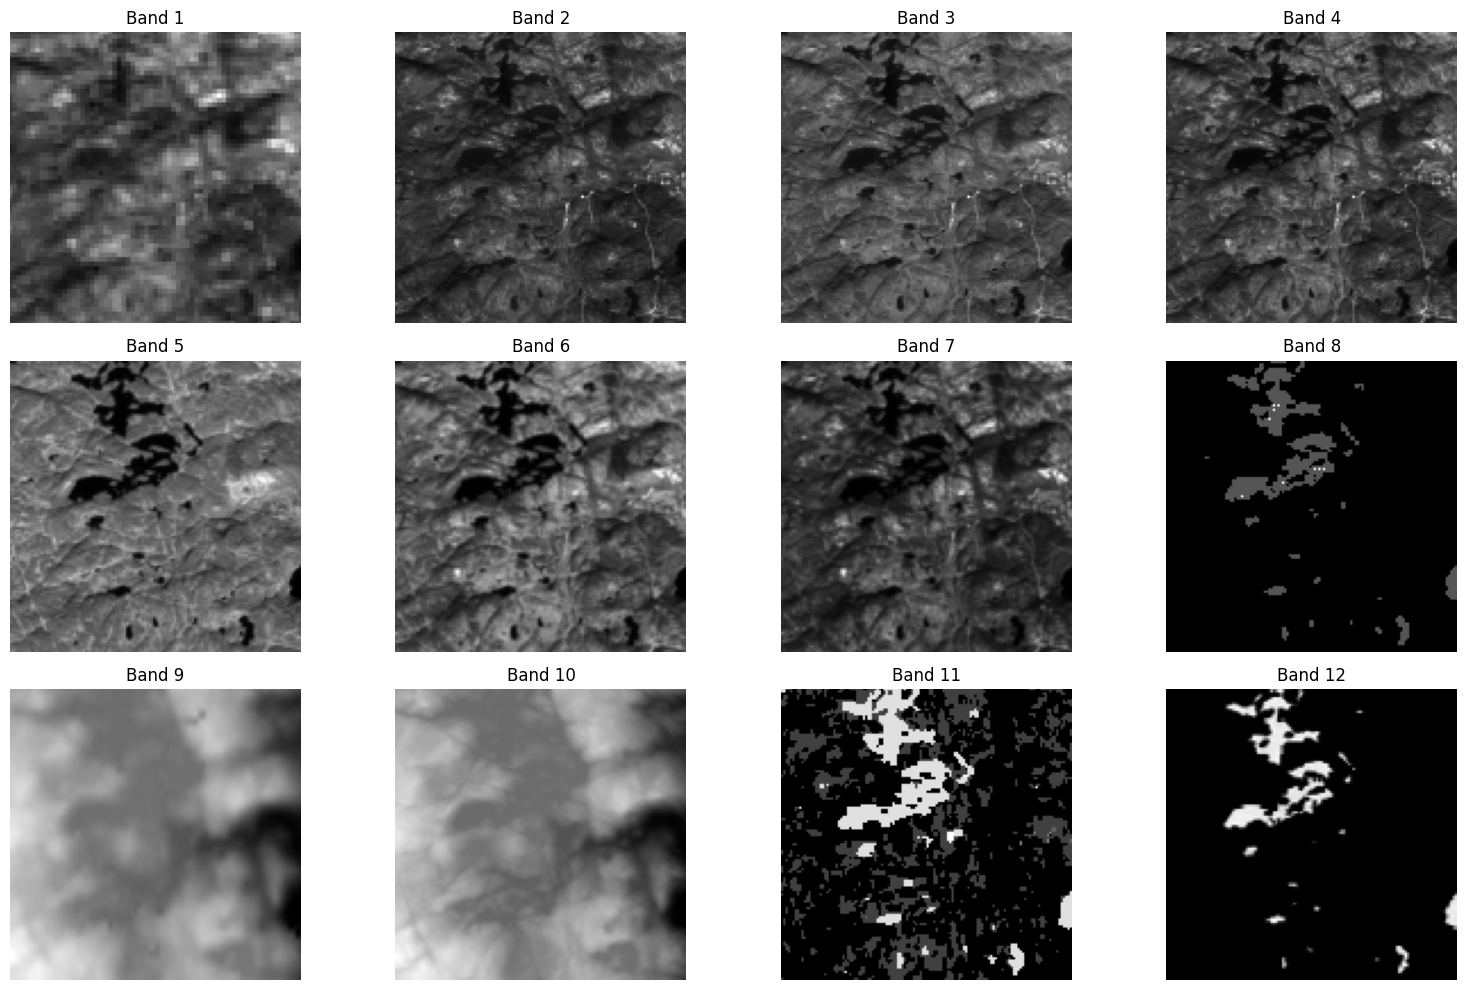

In [4]:
plt.figure(figsize=(16,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(sample_image[:,:,i], cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Model Arch

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))

        bridge = self.bridge(self.pool3(d3))

        u3 = self.up3(bridge)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)


In [6]:
model = UNet(12, 1)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)


Total parameters: 7708161
Trainable parameters: 7708161


### Model A (6 Bands)

In [7]:
selected_bands = [0, 1, 4, 5, 6, 11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)


        with rasterio.open(img_path) as src:
            image = src.read()  

        image = np.transpose(image, (1, 2, 0))  
        image = image[:, :, selected_bands]
        image = image.astype(np.float32)


        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            raise ValueError(f"Mask not found: {mask_path}")

        mask = (mask > 0).astype(np.float32)  
        image = torch.tensor(image).permute(2, 0, 1)  
        mask = torch.tensor(mask).unsqueeze(0)       

        return image, mask


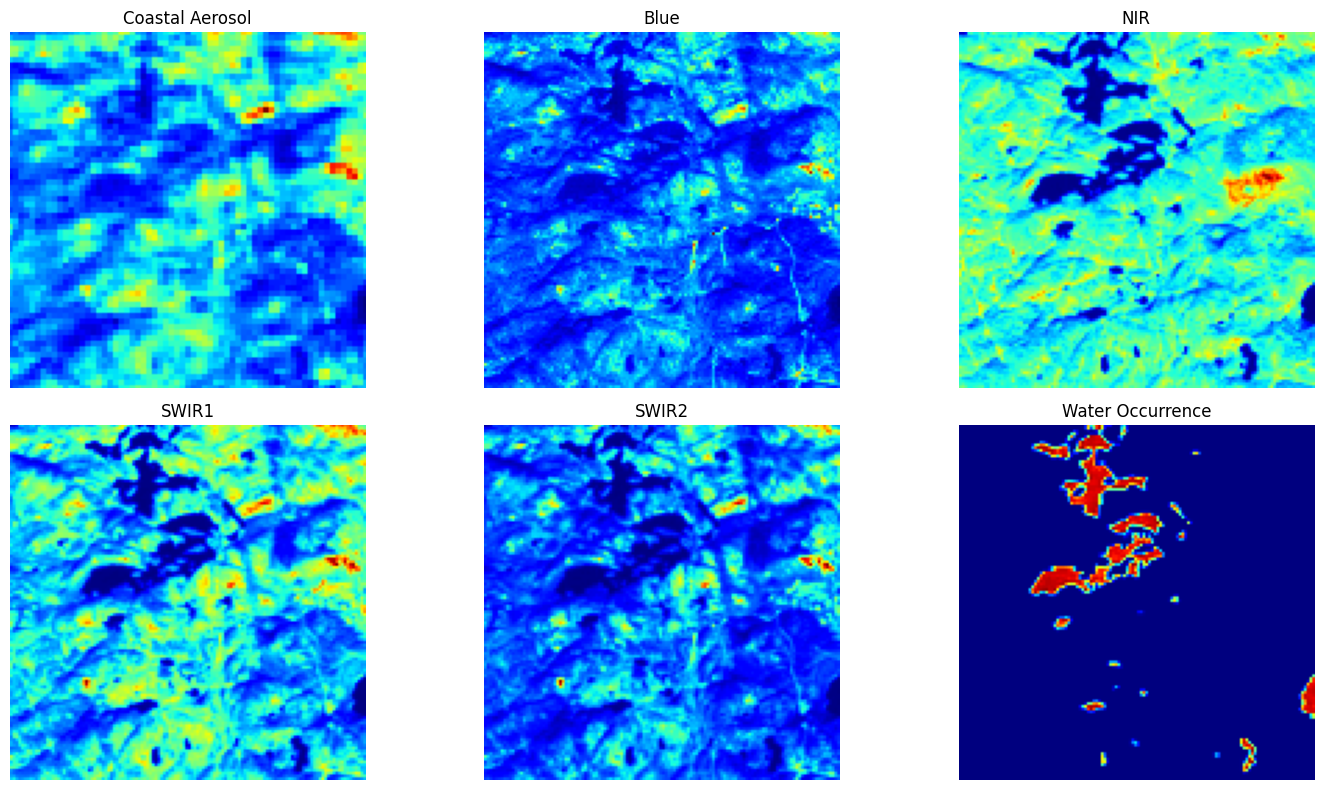

In [8]:
plt.figure(figsize=(15,8))

band_names = [
    "Coastal Aerosol",
    "Blue",
    "NIR",
    "SWIR1",
    "SWIR2",
    "Water Occurrence"
]

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(sample_image[:,:,selected_bands[i]], cmap='jet')
    plt.title(band_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
from torch.utils.data import Subset

dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



In [10]:
model = UNet(in_channels=6, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [11]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []



def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)


    return iou.item() , dice.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou , dice = calculate_metrics(preds, masks)
        train_iou += iou
        train_dice += dice


        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou , dice = calculate_metrics(preds, masks)

            val_iou += iou
            val_dice += dice

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f} | Dice:{train_dice:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f} | Dice:{val_dice:.4f}\n")



Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.68it/s, val_loss=0.651]



Epoch 1
Train -> Loss:0.4771 | IoU:0.5292 | Dice:0.6818
Val   -> Loss:0.6415 | IoU:0.0000 | Dice:0.0000



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.86it/s, val_loss=0.529]



Epoch 2
Train -> Loss:0.3812 | IoU:0.6287 | Dice:0.7679
Val   -> Loss:0.4992 | IoU:0.2642 | Dice:0.4167



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s, val_loss=0.43] 



Epoch 3
Train -> Loss:0.3608 | IoU:0.6321 | Dice:0.7649
Val   -> Loss:0.3989 | IoU:0.5191 | Dice:0.6795



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  8.06it/s, val_loss=0.355]



Epoch 4
Train -> Loss:0.3374 | IoU:0.6505 | Dice:0.7845
Val   -> Loss:0.3368 | IoU:0.6351 | Dice:0.7735



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  8.16it/s, val_loss=0.332]



Epoch 5
Train -> Loss:0.3355 | IoU:0.6504 | Dice:0.7848
Val   -> Loss:0.3384 | IoU:0.6589 | Dice:0.7924



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.73it/s, val_loss=0.339]



Epoch 6
Train -> Loss:0.3230 | IoU:0.6545 | Dice:0.7880
Val   -> Loss:0.3288 | IoU:0.6517 | Dice:0.7864



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s, val_loss=0.312]



Epoch 7
Train -> Loss:0.3189 | IoU:0.6495 | Dice:0.7859
Val   -> Loss:0.2936 | IoU:0.6695 | Dice:0.7994



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s, val_loss=0.313]



Epoch 8
Train -> Loss:0.3054 | IoU:0.6663 | Dice:0.7972
Val   -> Loss:0.2959 | IoU:0.6527 | Dice:0.7872



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.34it/s, val_loss=0.321]



Epoch 9
Train -> Loss:0.3168 | IoU:0.6184 | Dice:0.7523
Val   -> Loss:0.3236 | IoU:0.6697 | Dice:0.7983



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.96it/s, val_loss=0.319]



Epoch 10
Train -> Loss:0.3052 | IoU:0.6570 | Dice:0.7892
Val   -> Loss:0.3083 | IoU:0.6770 | Dice:0.8060



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.76it/s, val_loss=0.279]



Epoch 11
Train -> Loss:0.2856 | IoU:0.6895 | Dice:0.8137
Val   -> Loss:0.2830 | IoU:0.6941 | Dice:0.8171



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.95it/s, val_loss=0.279]



Epoch 12
Train -> Loss:0.2752 | IoU:0.7071 | Dice:0.8274
Val   -> Loss:0.2689 | IoU:0.6704 | Dice:0.8000



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.65it/s, val_loss=0.279]



Epoch 13
Train -> Loss:0.2688 | IoU:0.7092 | Dice:0.8289
Val   -> Loss:0.2731 | IoU:0.6875 | Dice:0.8119



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.88it/s, val_loss=0.296]



Epoch 14
Train -> Loss:0.2676 | IoU:0.7085 | Dice:0.8270
Val   -> Loss:0.2977 | IoU:0.6670 | Dice:0.7970



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  8.00it/s, val_loss=0.283]



Epoch 15
Train -> Loss:0.2721 | IoU:0.7021 | Dice:0.8223
Val   -> Loss:0.2846 | IoU:0.6830 | Dice:0.8100



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s, val_loss=0.287]



Epoch 16
Train -> Loss:0.2714 | IoU:0.6998 | Dice:0.8191
Val   -> Loss:0.2716 | IoU:0.6912 | Dice:0.8158



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.72it/s, val_loss=0.25] 



Epoch 17
Train -> Loss:0.2609 | IoU:0.7211 | Dice:0.8362
Val   -> Loss:0.2547 | IoU:0.7027 | Dice:0.8230



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.84it/s, val_loss=0.297]



Epoch 18
Train -> Loss:0.2416 | IoU:0.7402 | Dice:0.8491
Val   -> Loss:0.2770 | IoU:0.6837 | Dice:0.8098



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s, val_loss=0.253]



Epoch 19
Train -> Loss:0.2385 | IoU:0.7365 | Dice:0.8459
Val   -> Loss:0.2467 | IoU:0.7105 | Dice:0.8290



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s, val_loss=0.271]


Epoch 20
Train -> Loss:0.2301 | IoU:0.7525 | Dice:0.8576
Val   -> Loss:0.2534 | IoU:0.6932 | Dice:0.8174



In [12]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
dice = (2 * TP) / (2 * TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"Dice:     {dice:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


Eval:
Precision: 0.7899
Recall:    0.9339
IoU:       0.7480
Dice:     0.8559
F1-score:  0.8559


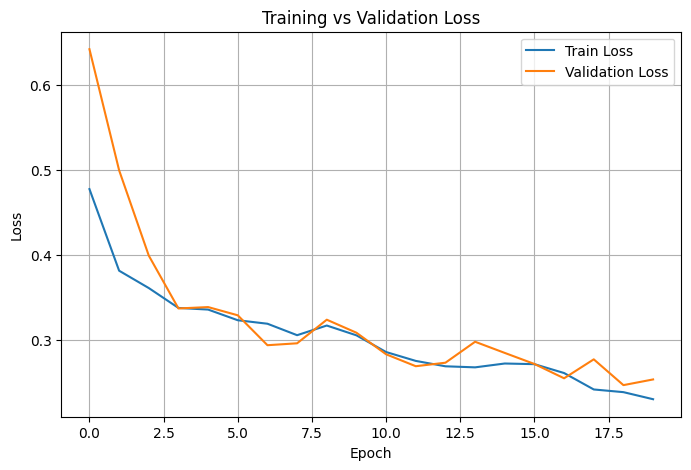

In [13]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


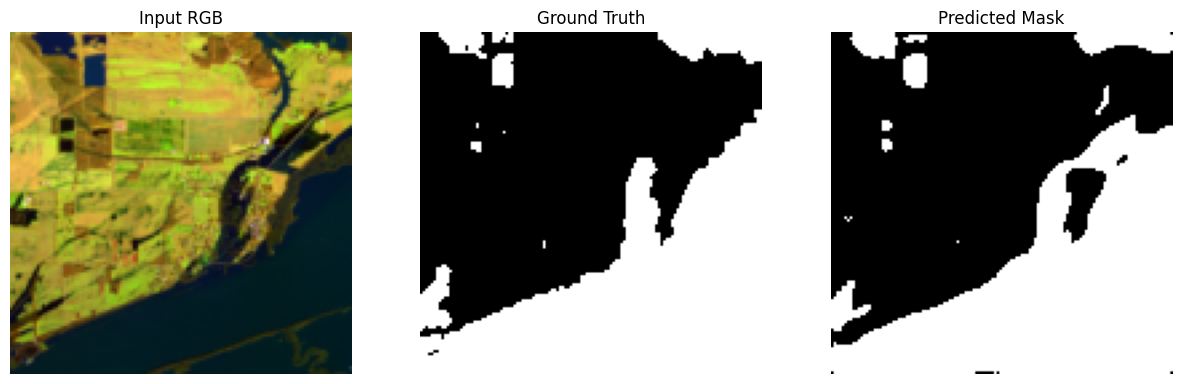

In [14]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


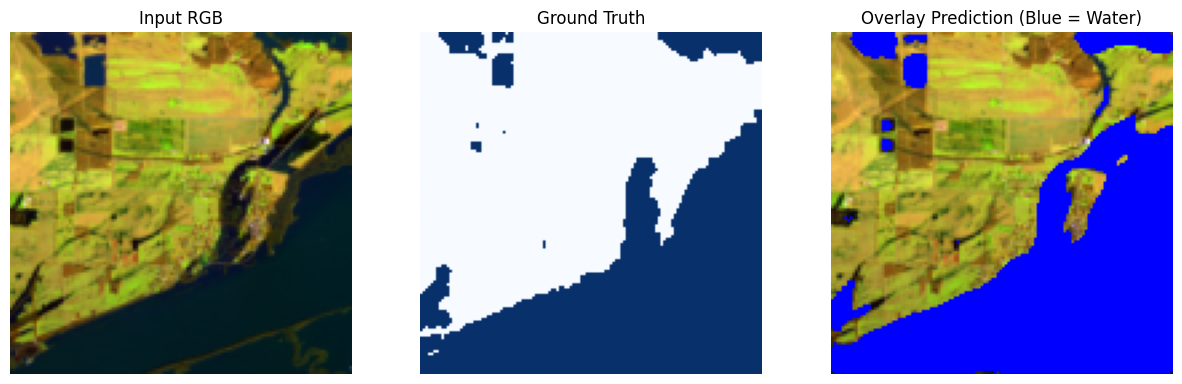

In [15]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Model B (6 Bands + NDWI)

In [16]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))

        self.selected_bands = [0, 1, 4, 5, 6, 11]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.label_dir, mask_name)

        with rasterio.open(img_path) as src:
            full_image = src.read()  

        full_image = np.transpose(full_image, (1,2,0)).astype(np.float32)
        image = full_image[:, :, self.selected_bands]

        green = full_image[:, :, 2]
        nir = full_image[:, :, 4]

        ndwi = (green - nir) / (green + nir + 1e-8)
        ndwi = np.expand_dims(ndwi, axis=-1)
        image = np.concatenate([image, ndwi], axis=-1)

        for c in range(image.shape[-1]):
            band = image[:, :, c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[:, :, c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        image = torch.tensor(image).permute(2,0,1)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=7, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4 , weight_decay=1e-4)


In [18]:
dataset = WaterDataset(image_dir, label_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [19]:
import matplotlib.pyplot as plt

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []



def calculate_metrics(preds, masks):
    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)


    return iou.item() , dice.item()


for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        iou , dice = calculate_metrics(preds, masks)
        train_iou += iou
        train_dice += dice


        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)


    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0


    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            iou , dice = calculate_metrics(preds, masks)

            val_iou += iou
            val_dice += dice

            val_bar.set_postfix(val_loss=loss.item())

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)


    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f} | Dice:{train_dice:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f} | Dice:{val_dice:.4f}\n")



Epoch 1/20 [Training]:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Epoch 1/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.63it/s, val_loss=0.572]



Epoch 1
Train -> Loss:0.4931 | IoU:0.4997 | Dice:0.6494
Val   -> Loss:0.5925 | IoU:0.0000 | Dice:0.0000



Epoch 2/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s, val_loss=0.482]



Epoch 2
Train -> Loss:0.3863 | IoU:0.6114 | Dice:0.7550
Val   -> Loss:0.5140 | IoU:0.3050 | Dice:0.4644



Epoch 3/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s, val_loss=0.355]



Epoch 3
Train -> Loss:0.3703 | IoU:0.6101 | Dice:0.7528
Val   -> Loss:0.3735 | IoU:0.5881 | Dice:0.7388



Epoch 4/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s, val_loss=0.318]



Epoch 4
Train -> Loss:0.3558 | IoU:0.6251 | Dice:0.7606
Val   -> Loss:0.3296 | IoU:0.6569 | Dice:0.7910



Epoch 5/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.43it/s, val_loss=0.34] 



Epoch 5
Train -> Loss:0.3351 | IoU:0.6628 | Dice:0.7952
Val   -> Loss:0.3385 | IoU:0.6540 | Dice:0.7879



Epoch 6/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.02it/s, val_loss=0.285]



Epoch 6
Train -> Loss:0.3264 | IoU:0.6588 | Dice:0.7909
Val   -> Loss:0.2963 | IoU:0.6802 | Dice:0.8068



Epoch 7/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s, val_loss=0.29] 



Epoch 7
Train -> Loss:0.3179 | IoU:0.6654 | Dice:0.7950
Val   -> Loss:0.3021 | IoU:0.6817 | Dice:0.8081



Epoch 8/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s, val_loss=0.247]



Epoch 8
Train -> Loss:0.3097 | IoU:0.6775 | Dice:0.8035
Val   -> Loss:0.2683 | IoU:0.6642 | Dice:0.7961



Epoch 9/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, val_loss=0.247]



Epoch 9
Train -> Loss:0.3011 | IoU:0.6831 | Dice:0.8102
Val   -> Loss:0.2639 | IoU:0.6861 | Dice:0.8114



Epoch 10/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s, val_loss=0.248]



Epoch 10
Train -> Loss:0.2921 | IoU:0.6895 | Dice:0.8139
Val   -> Loss:0.2588 | IoU:0.6819 | Dice:0.8077



Epoch 11/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s, val_loss=0.26] 



Epoch 11
Train -> Loss:0.2917 | IoU:0.6945 | Dice:0.8179
Val   -> Loss:0.2644 | IoU:0.7117 | Dice:0.8287



Epoch 12/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s, val_loss=0.22] 



Epoch 12
Train -> Loss:0.3006 | IoU:0.6622 | Dice:0.7933
Val   -> Loss:0.2414 | IoU:0.6741 | Dice:0.8019



Epoch 13/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s, val_loss=0.284]



Epoch 13
Train -> Loss:0.2844 | IoU:0.6706 | Dice:0.7994
Val   -> Loss:0.2839 | IoU:0.6845 | Dice:0.8090



Epoch 14/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s, val_loss=0.226]



Epoch 14
Train -> Loss:0.2790 | IoU:0.7009 | Dice:0.8229
Val   -> Loss:0.2469 | IoU:0.7048 | Dice:0.8250



Epoch 15/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s, val_loss=0.237]



Epoch 15
Train -> Loss:0.2764 | IoU:0.6933 | Dice:0.8157
Val   -> Loss:0.2485 | IoU:0.7018 | Dice:0.8222



Epoch 16/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s, val_loss=0.281]



Epoch 16
Train -> Loss:0.2640 | IoU:0.7087 | Dice:0.8276
Val   -> Loss:0.3023 | IoU:0.6612 | Dice:0.7922



Epoch 17/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, val_loss=0.209]



Epoch 17
Train -> Loss:0.2680 | IoU:0.6907 | Dice:0.8147
Val   -> Loss:0.2262 | IoU:0.7045 | Dice:0.8240



Epoch 18/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, val_loss=0.22] 



Epoch 18
Train -> Loss:0.2509 | IoU:0.7290 | Dice:0.8417
Val   -> Loss:0.2359 | IoU:0.7080 | Dice:0.8266



Epoch 19/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s, val_loss=0.216]



Epoch 19
Train -> Loss:0.2625 | IoU:0.7020 | Dice:0.8237
Val   -> Loss:0.2310 | IoU:0.6805 | Dice:0.8081



Epoch 20/20 [Validation]: 100%|██████████| 3/3 [00:00<00:00,  6.10it/s, val_loss=0.266]


Epoch 20
Train -> Loss:0.2547 | IoU:0.7150 | Dice:0.8318
Val   -> Loss:0.2697 | IoU:0.6891 | Dice:0.8124



In [20]:
model.eval()

TP = FP = FN = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.2).float()

        TP += (preds * masks).sum().item()
        FP += (preds * (1 - masks)).sum().item()
        FN += ((1 - preds) * masks).sum().item()

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)
dice = (2 * TP) / (2 * TP + FP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\nEval:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"Dice:       {dice:.4f}")
print(f"F1-score:  {f1:.4f}")


Testing:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Testing: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Eval:
Precision: 0.5097
Recall:    0.9778
IoU:       0.5039
Dice:       0.6701
F1-score:  0.6701


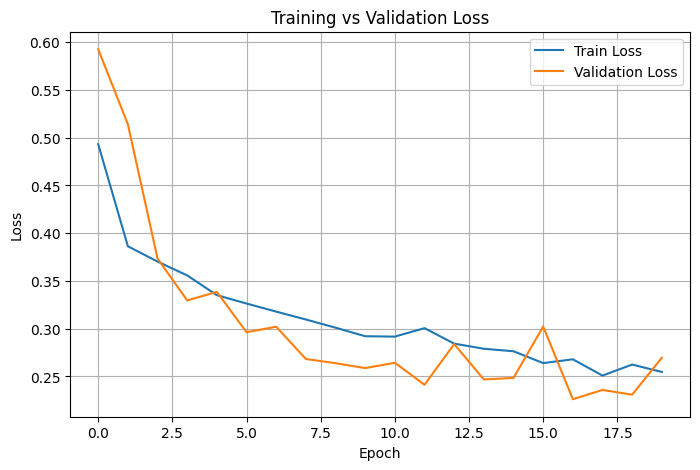

In [21]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


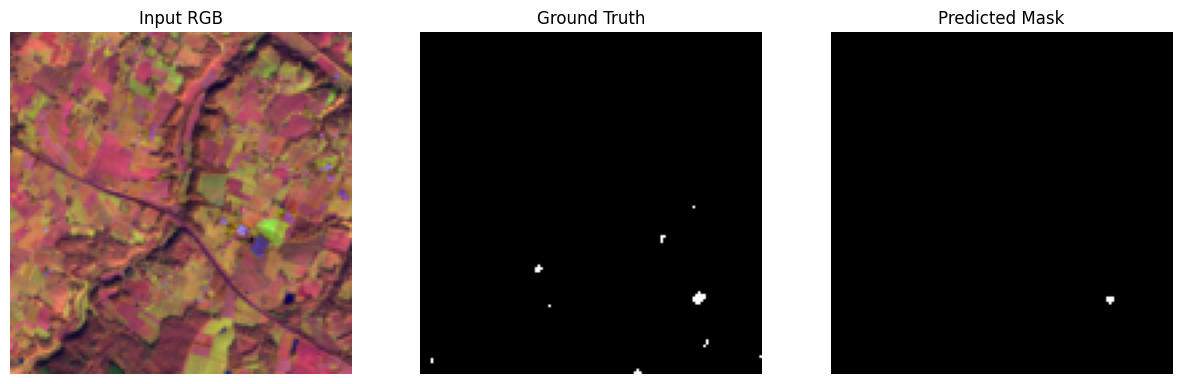

In [22]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = torch.sigmoid(model(images))
    preds = (outputs > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0][0]
pred = preds[0][0]

rgb = torch.stack([img[3], img[2], img[1]], dim=0)
rgb = rgb.permute(1,2,0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


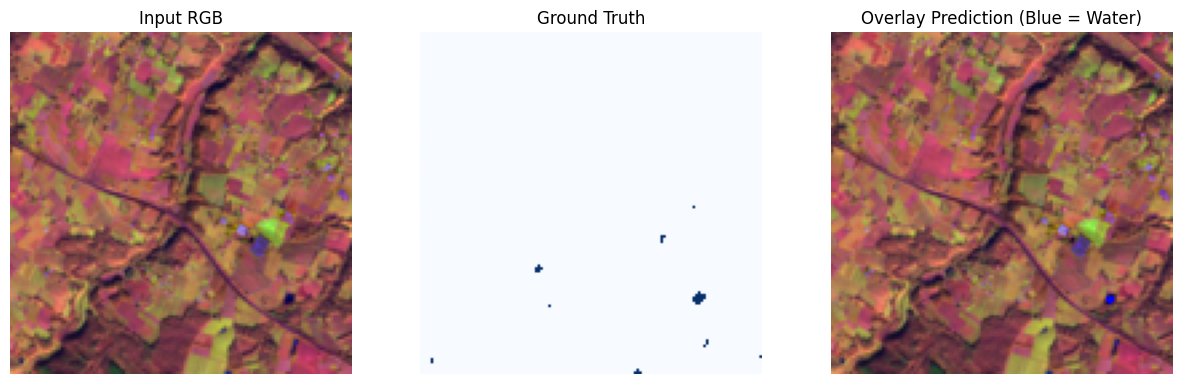

In [23]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()


### Updates 

In [ ]:
## we need to make the min-max norm to the whole dataset not on a sample image ✅
## work with dice loss ✅
## pretrained model deeplab , Huggingface , segmentation with pytorch 


In [1]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Mask2FormerForUniversalSegmentation
import torch.nn as nn

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_5164\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_5164\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [3]:
with rasterio.open(os.path.join(image_dir, image_files[0])) as src:
    sample_image = src.read()  

sample_image = np.transpose(sample_image, (1, 2, 0))  # convert to (H, W, C)

sample_mask = cv2.imread(os.path.join(label_dir, label_files[0]), 0)

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

sample_image = sample_image.astype(np.float32)

num_channels = 12
total_pixels = 0
global_sum = np.zeros(num_channels, dtype=np.float64)
global_sq_sum = np.zeros(num_channels, dtype=np.float64)

for img_name in tqdm(image_files):
    with rasterio.open(os.path.join(image_dir, img_name)) as src:
        image = src.read().astype(np.float32)

    C, H, W = image.shape
    total_pixels += H * W

    for c in range(C):
        band = image[c]
        global_sum[c] += band.sum()
        global_sq_sum[c] += (band ** 2).sum()

for c in range(image.shape[-1]):
    band = image[:, :, c]
    min_val = band.min()
    max_val = band.max()
    if max_val > min_val:
        image[:, :, c] = (band - min_val) / (max_val - min_val)


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Image shape: (128, 128, 12)
Mask shape: (128, 128)


100%|██████████| 306/306 [00:01<00:00, 263.52it/s]


In [4]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(
            self.label_dir,
            os.path.splitext(img_name)[0] + ".png"
        )

        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

        image = image[self.selected_bands]  # (6,H,W)

        # Min-Max normalize per band
        for c in range(image.shape[0]):
            band = image[c]
            min_val = band.min()
            max_val = band.max()
            if max_val > min_val:
                image[c] = (band - min_val) / (max_val - min_val)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.int64)

        return torch.tensor(image), torch.tensor(mask)

In [5]:
selected_bands = [0, 1, 4, 5, 6, 11]
dataset = WaterDataset(image_dir, label_dir, selected_bands)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [6]:
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "mfaytin/mask2former-satellite",
    num_labels=2,  # background + water
    ignore_mismatched_sizes=True
)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at mfaytin/mask2former-satellite and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([9, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([9]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
old_conv = model.model.pixel_level_module.encoder.embeddings.patch_embeddings.projection

new_conv = nn.Conv2d(
    in_channels=6,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding
)

# Copy first 3 RGB weights
new_conv.weight.data[:, :3] = old_conv.weight.data
new_conv.weight.data[:, 3:] = old_conv.weight.data[:, :3]

model.model.pixel_level_module.encoder.embeddings.patch_embeddings.projection = new_conv

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5 , weight_decay= 2e-5)

epochs = 20

train_losses = []
val_losses = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

In [13]:
def calculate_metrics(preds, masks):

    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = (preds * masks).sum()
    FP = (preds * (1 - masks)).sum()
    FN = ((1 - preds) * masks).sum()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return precision.item(), recall.item(), iou.item(), dice.item(), f1.item()

In [14]:
import torch.nn.functional as F

def get_segmentation_logits(outputs):

    # (B, num_queries, num_classes)
    class_logits = outputs.class_queries_logits

    # (B, num_queries, H, W)
    mask_logits = outputs.masks_queries_logits

    # Convert class logits to probabilities
    class_probs = F.softmax(class_logits, dim=-1)

    # Remove background class from class probs
    class_probs = class_probs[..., :-1]

    # Compute segmentation logits
    seg_logits = torch.einsum("bqc,bqhw->bchw", class_probs, mask_logits)

    return seg_logits

In [15]:
for epoch in range(epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(pixel_values=images)

        logits = get_segmentation_logits(outputs)

        logits = F.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        loss = criterion(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        _, _, iou, dice, _ = calculate_metrics(preds, masks)

        train_iou += iou
        train_dice += dice

        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(pixel_values=images)

            logits = get_segmentation_logits(outputs)

            logits = F.interpolate(
                logits,
                size=masks.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            loss = criterion(logits, masks)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)

            _, _, iou, dice, _ = calculate_metrics(preds, masks)

            val_iou += iou
            val_dice += dice

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> Loss:{train_loss:.4f} | IoU:{train_iou:.4f} | Dice:{train_dice:.4f}")
    print(f"Val   -> Loss:{val_loss:.4f} | IoU:{val_iou:.4f} | Dice:{val_dice:.4f}\n")

Epoch 1/20 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Epoch 1/20 [Val]: 100%|██████████| 3/3 [00:16<00:00,  5.33s/it]



Epoch 1
Train -> Loss:0.8976 | IoU:0.0985 | Dice:0.1614
Val   -> Loss:0.6897 | IoU:0.0415 | Dice:0.0761



Epoch 2/20 [Val]: 100%|██████████| 3/3 [00:14<00:00,  4.85s/it]



Epoch 2
Train -> Loss:0.5359 | IoU:0.1433 | Dice:0.2067
Val   -> Loss:0.7271 | IoU:0.0000 | Dice:0.0000



Epoch 3/20 [Val]: 100%|██████████| 3/3 [00:16<00:00,  5.39s/it]



Epoch 3
Train -> Loss:0.4897 | IoU:0.1979 | Dice:0.2895
Val   -> Loss:0.5574 | IoU:0.2852 | Dice:0.4376



Epoch 4/20 [Val]: 100%|██████████| 3/3 [00:22<00:00,  7.63s/it]



Epoch 4
Train -> Loss:0.4440 | IoU:0.2275 | Dice:0.3254
Val   -> Loss:0.5445 | IoU:0.2720 | Dice:0.4182



Epoch 5/20 [Val]: 100%|██████████| 3/3 [00:16<00:00,  5.42s/it]



Epoch 5
Train -> Loss:0.4033 | IoU:0.1593 | Dice:0.2432
Val   -> Loss:0.5185 | IoU:0.2532 | Dice:0.4030



Epoch 6/20 [Val]: 100%|██████████| 3/3 [00:14<00:00,  4.77s/it]



Epoch 6
Train -> Loss:0.3773 | IoU:0.3660 | Dice:0.5275
Val   -> Loss:0.4246 | IoU:0.5507 | Dice:0.7039



Epoch 7/20 [Val]: 100%|██████████| 3/3 [00:18<00:00,  6.04s/it]



Epoch 7
Train -> Loss:0.3581 | IoU:0.5161 | Dice:0.6721
Val   -> Loss:0.4054 | IoU:0.5767 | Dice:0.7226



Epoch 8/20 [Val]: 100%|██████████| 3/3 [00:13<00:00,  4.42s/it]



Epoch 8
Train -> Loss:0.3134 | IoU:0.5572 | Dice:0.7067
Val   -> Loss:0.3739 | IoU:0.5771 | Dice:0.7234



Epoch 9/20 [Val]: 100%|██████████| 3/3 [00:12<00:00,  4.15s/it]



Epoch 9
Train -> Loss:0.2751 | IoU:0.5947 | Dice:0.7415
Val   -> Loss:0.3793 | IoU:0.5804 | Dice:0.7231



Epoch 10/20 [Val]: 100%|██████████| 3/3 [00:17<00:00,  5.76s/it]



Epoch 10
Train -> Loss:0.2556 | IoU:0.6206 | Dice:0.7609
Val   -> Loss:0.4656 | IoU:0.5445 | Dice:0.6933



Epoch 11/20 [Val]: 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]



Epoch 11
Train -> Loss:0.2540 | IoU:0.5704 | Dice:0.6987
Val   -> Loss:0.3920 | IoU:0.5382 | Dice:0.6905



Epoch 12/20 [Val]: 100%|██████████| 3/3 [00:19<00:00,  6.56s/it]



Epoch 12
Train -> Loss:0.2497 | IoU:0.5917 | Dice:0.7307
Val   -> Loss:0.3458 | IoU:0.6248 | Dice:0.7592



Epoch 13/20 [Val]: 100%|██████████| 3/3 [00:15<00:00,  5.13s/it]



Epoch 13
Train -> Loss:0.2334 | IoU:0.6359 | Dice:0.7745
Val   -> Loss:0.3426 | IoU:0.6190 | Dice:0.7582



Epoch 14/20 [Val]: 100%|██████████| 3/3 [00:14<00:00,  4.71s/it]



Epoch 14
Train -> Loss:0.2382 | IoU:0.6549 | Dice:0.7901
Val   -> Loss:0.3232 | IoU:0.6253 | Dice:0.7621



Epoch 15/20 [Val]: 100%|██████████| 3/3 [00:14<00:00,  4.69s/it]



Epoch 15
Train -> Loss:0.2171 | IoU:0.6677 | Dice:0.7950
Val   -> Loss:0.3222 | IoU:0.6302 | Dice:0.7646



Epoch 16/20 [Val]: 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]



Epoch 16
Train -> Loss:0.2199 | IoU:0.6679 | Dice:0.7962
Val   -> Loss:0.3425 | IoU:0.6283 | Dice:0.7625



Epoch 17/20 [Val]: 100%|██████████| 3/3 [00:12<00:00,  4.25s/it]



Epoch 17
Train -> Loss:0.2036 | IoU:0.6906 | Dice:0.8112
Val   -> Loss:0.3372 | IoU:0.6261 | Dice:0.7604



Epoch 18/20 [Val]: 100%|██████████| 3/3 [00:13<00:00,  4.42s/it]



Epoch 18
Train -> Loss:0.1992 | IoU:0.6816 | Dice:0.8072
Val   -> Loss:0.3144 | IoU:0.6313 | Dice:0.7685



Epoch 19/20 [Val]: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]



Epoch 19
Train -> Loss:0.1937 | IoU:0.6994 | Dice:0.8206
Val   -> Loss:0.3321 | IoU:0.6367 | Dice:0.7706



Epoch 20/20 [Val]: 100%|██████████| 3/3 [00:18<00:00,  6.08s/it]


Epoch 20
Train -> Loss:0.1940 | IoU:0.6878 | Dice:0.8114
Val   -> Loss:0.3116 | IoU:0.6466 | Dice:0.7801



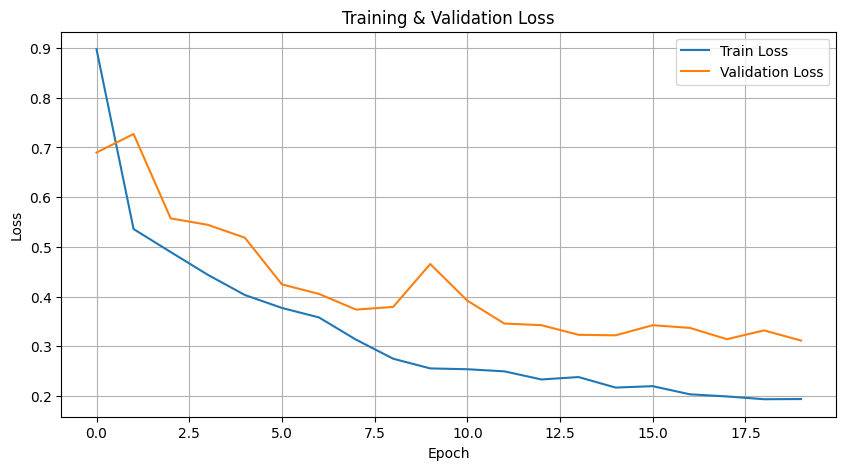

In [16]:
plt.figure(figsize=(10,5))

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

In [17]:
model.eval()

precision_total = 0
recall_total = 0
iou_total = 0
dice_total = 0
f1_total = 0

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(pixel_values=images)

        logits = get_segmentation_logits(outputs)

        logits = F.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        preds = torch.argmax(logits, dim=1)

        precision, recall, iou, dice, f1 = calculate_metrics(preds, masks)

        precision_total += precision
        recall_total += recall
        iou_total += iou
        dice_total += dice
        f1_total += f1

# Average over batches
precision = precision_total / len(test_loader)
recall = recall_total / len(test_loader)
iou = iou_total / len(test_loader)
dice = dice_total / len(test_loader)
f1 = f1_total / len(test_loader)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"Dice:      {dice:.4f}")
print(f"F1-score:  {f1:.4f}")

Testing: 100%|██████████| 3/3 [00:21<00:00,  7.17s/it]

Precision: 0.8730
Recall:    0.7395
IoU:       0.6665
Dice:      0.7995
F1-score:  0.7995


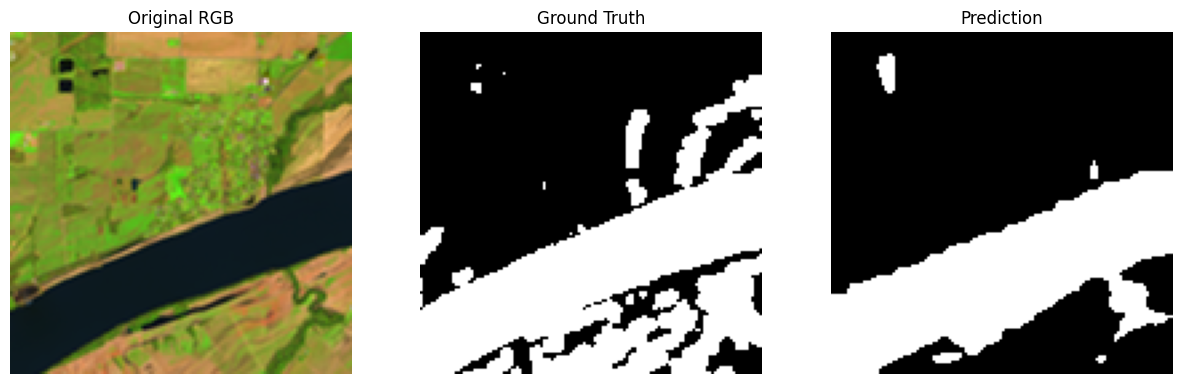

In [19]:
model.eval()

images, masks = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(pixel_values=images)
    logits = get_segmentation_logits(outputs)

    logits = F.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )

    preds = torch.argmax(logits, dim=1)

# Move to CPU
image = images[0].cpu().numpy()
gt = masks[0].numpy()
pred = preds[0].cpu().numpy()

# Convert 6-band image to RGB for visualization
# Adjust indices depending on your band meaning
rgb = np.stack([image[3], image[2], image[1]], axis=-1)

# Normalize RGB for display
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Prediction")
plt.axis("off")

plt.show()